In [1]:
%matplotlib inline
from itertools import chain

from tqdm import trange
import numpy as np
from scipy import linalg
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import seaborn as sns

sns.set(style="white")
random_seed = 123

In [2]:
def generate_data(num_mode, except_num, radius=2,
                  center=(0, 0), sigma=0.1, num_data_per_class=100000):
    total_data = {}
    
    t = np.linspace(0, 2*np.pi, 13)
    x = np.cos(t)*radius + center[0]
    y = np.sin(t)*radius + center[1]

    plt.figure()
    plt.plot(x,y)

    modes = np.vstack([x, y]).T

    for idx, mode in enumerate(modes[except_num:]):
        x = np.random.normal(mode[0], sigma, num_data_per_class)
        y = np.random.normal(mode[1], sigma, num_data_per_class)
        total_data[idx] = np.vstack([x, y]).T
        
        plt.plot(x, y)

    all_points = np.vstack([values for values in total_data.values()])
    data_x, data_y = all_points[:,0], all_points[:,1]
    
    return total_data, all_points

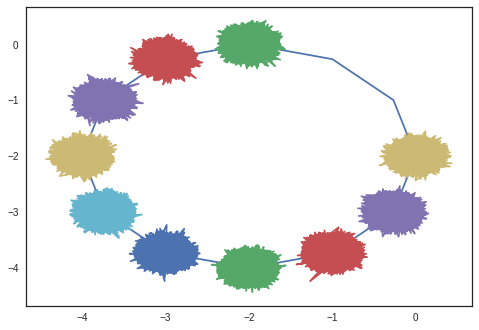

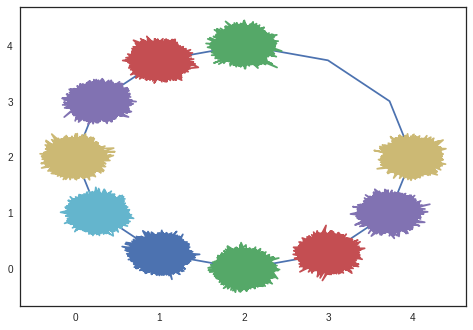

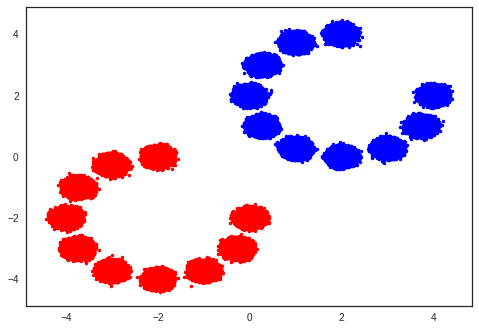

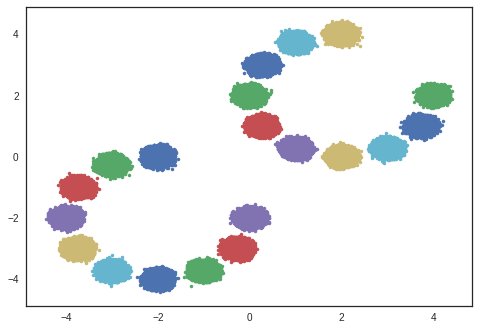

In [3]:
A_data_with_class, A_data = generate_data(13, 3, radius=2, center=(-2, -2))
B_data_with_class, B_data = generate_data(13, 3, radius=2, center=(2, 2))

A_train_np, A_test_np = train_test_split(A_data, test_size=0.33, random_state=random_seed)
B_train_np, B_test_np = train_test_split(B_data, test_size=0.33, random_state=random_seed)

def plot(data, color):
    plt.plot(data[:,0], data[:,1], color)

plt.figure()
#sns.kdeplot(data_x, data_y)
plot(A_data, 'r.')
plot(B_data, 'b.')

def plot_with_class(data_with_class):
    for key, value in data_with_class.items():
        plot(value, '.')

plt.figure()
plot_with_class(A_data_with_class)
plot_with_class(B_data_with_class)

In [4]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader


class ListModule(nn.Module):
    def __init__(self, *args):
        super(ListModule, self).__init__()
        idx = 0
        for module in args:
            self.add_module(str(idx), module)
            idx += 1

    def __getitem__(self, idx):
        if idx < 0 or idx >= len(self._modules):
            raise IndexError('index {} is out of range'.format(idx))
        it = iter(self._modules.values())
        for i in range(idx):
            next(it)
        return next(it)

    def __iter__(self):
        return iter(self._modules.values())

    def __len__(self):
        return len(self._modules)

In [5]:
# dataset loader
batch_size = 200
shuffle = False

A_train, A_test = torch.from_numpy(A_train_np).float(), torch.from_numpy(A_test_np).float()
B_train, B_test = torch.from_numpy(B_train_np).float(), torch.from_numpy(B_test_np).float()

A_train_loader = DataLoader(
    TensorDataset(A_train, A_train), batch_size=batch_size, shuffle=shuffle)
A_test_loader = DataLoader(
    TensorDataset(A_test, A_test), batch_size=batch_size, shuffle=shuffle)

B_train_loader = DataLoader(
    TensorDataset(B_train, B_train), batch_size=batch_size, shuffle=shuffle)
B_test_loader = DataLoader(
    TensorDataset(B_test, B_test), batch_size=batch_size, shuffle=shuffle)

In [ ]:
class Generator(nn.Module):
    def __init__(self, input_size, output_size, hidden_dims):
        super(Generator, self).__init__()
        self.layers = []
        
        prev_dim = input_size
        for hidden_dim in hidden_dims:
            self.layers.append(nn.Linear(prev_dim, hidden_dim))
            self.layers.append(nn.ReLU(True))
            prev_dim = hidden_dim
        self.layers.append(nn.Linear(prev_dim, output_size))
        
        self.layer_module = ListModule(*self.layers)
        
    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer(out)
        return out

class Discriminator(nn.Module):
    def __init__(self, input_size, output_size, hidden_dims):
        super(Discriminator, self).__init__()
        self.layers = []
        
        prev_dim = input_size
        for idx, hidden_dim in enumerate(hidden_dims):
            self.layers.append(nn.Linear(prev_dim, hidden_dim))
            self.layers.append(nn.ReLU(True))
            prev_dim = hidden_dim
            
        self.layers.append(nn.Linear(prev_dim, output_size))
        self.layers.append(nn.Sigmoid())
        
        self.layer_module = ListModule(*self.layers)

    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer(out)
        return out.view(-1, 1)

# network
hidden_dim = 128
g_num_layer = 3
d_num_layer = 5

G_AB = Generator(2, 2, [hidden_dim] * g_num_layer)
G_BA = Generator(2, 2, [hidden_dim] * g_num_layer)

D_A = Discriminator(2, 1, [hidden_dim] * d_num_layer)
D_B = Discriminator(2, 1, [hidden_dim] * d_num_layer)

G_AB.cuda()
G_BA.cuda()
D_A.cuda()
D_B.cuda()

# optimizer
lr = 0.0002
beta1 = 0.5
beta2 = 0.999

d = nn.MSELoss()
bce = nn.BCELoss()

optimizer_d = torch.optim.Adam(
    chain(D_A.parameters(), D_B.parameters()), lr=lr, betas=(beta1, beta2))
optimizer_g = torch.optim.Adam(
    chain(G_AB.parameters(), G_BA.parameters()), lr=lr, betas=(beta1, beta2))

# training
num_epoch = 50000

real_label = 1
fake_label = 0

real_tensor = Variable(torch.FloatTensor(batch_size).cuda())
_ = real_tensor.data.fill_(real_label)
print real_tensor.sum()

fake_tensor = Variable(torch.FloatTensor(batch_size).cuda())
_ = fake_tensor.data.fill_(fake_label)
print fake_tensor.sum()

Variable containing:
 200
[torch.cuda.FloatTensor of size 1 (GPU 0)]

Variable containing:
 0
[torch.cuda.FloatTensor of size 1 (GPU 0)]



  0%|          | 0/50000 [00:00<?, ?it/s]

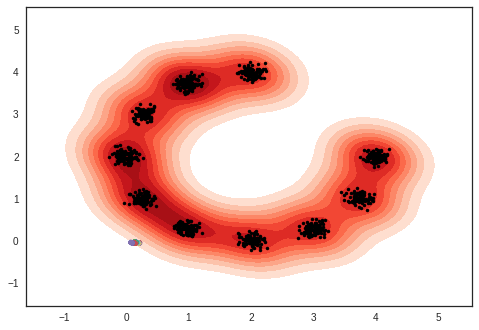

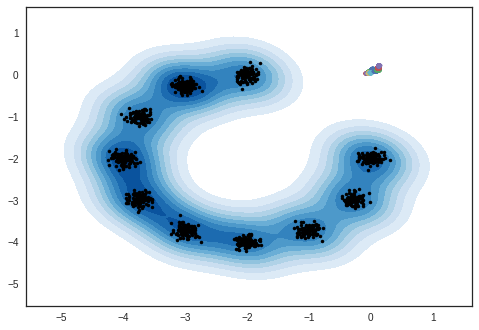

  5%|▍         | 2497/50000 [00:34<10:13, 77.40it/s]

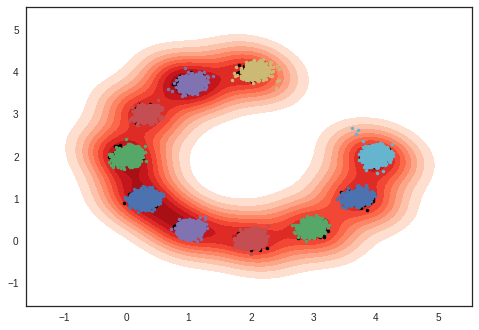

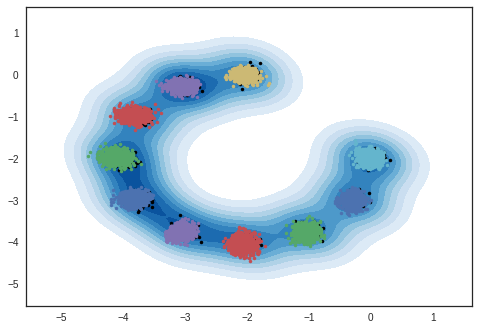

 10%|█         | 5000/50000 [01:07<09:41, 77.35it/s]

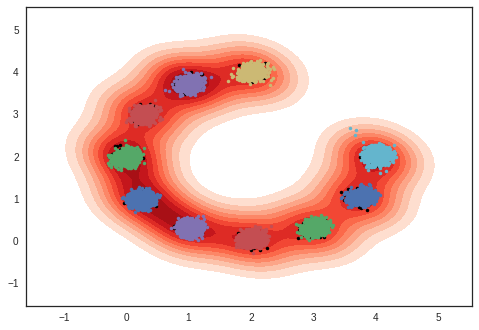

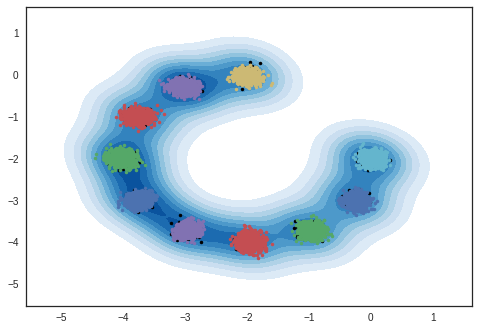

 15%|█▍        | 7496/50000 [01:41<09:13, 76.75it/s]

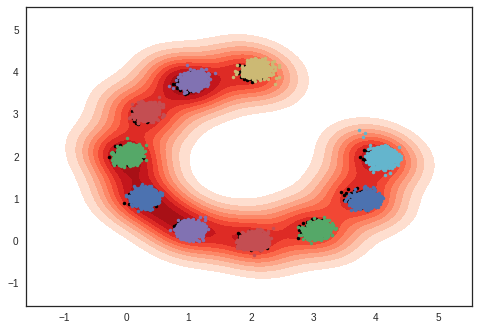

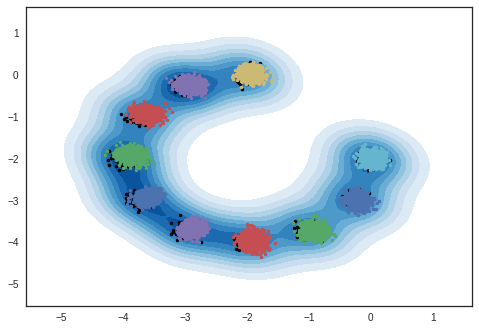

 20%|█▉        | 9998/50000 [02:14<08:35, 77.58it/s]

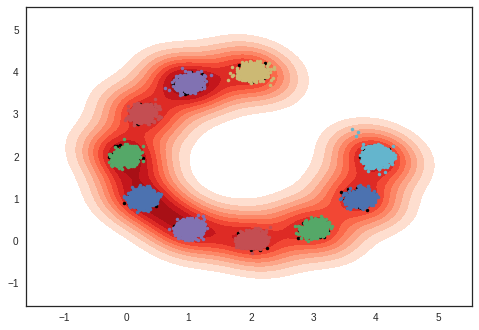

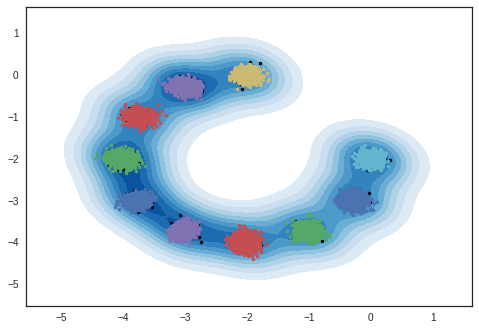

 25%|██▍       | 12499/50000 [02:48<08:05, 77.23it/s]

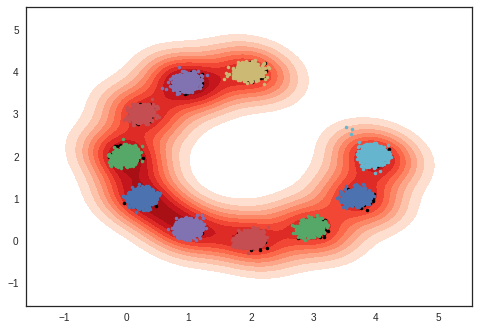

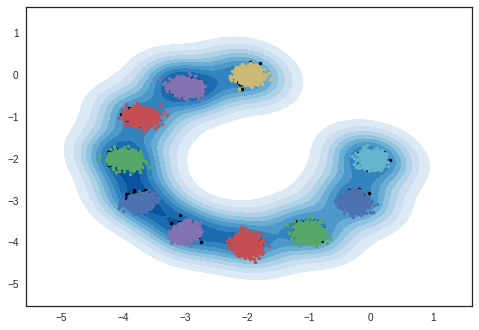

 30%|██▉       | 14999/50000 [03:23<07:41, 75.89it/s]

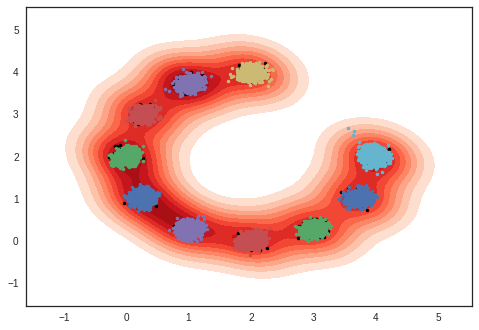

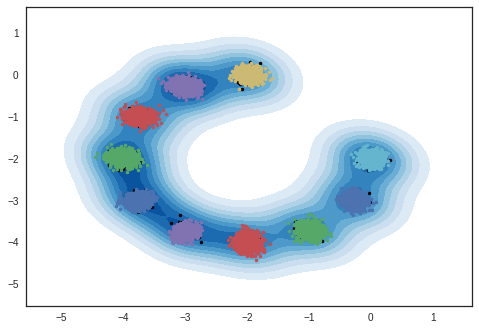

 35%|███▌      | 17500/50000 [03:56<06:59, 77.53it/s]

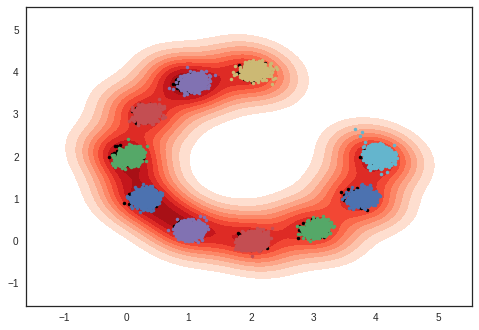

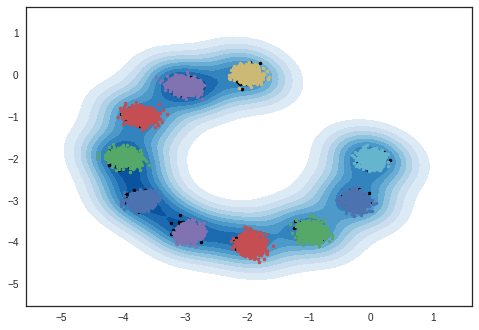

 40%|███▉      | 19999/50000 [04:30<06:25, 77.72it/s]

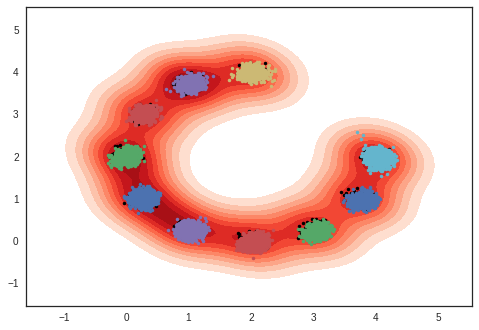

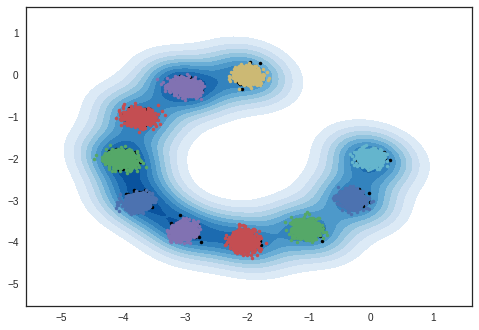

 45%|████▍     | 22497/50000 [05:03<05:51, 78.18it/s]

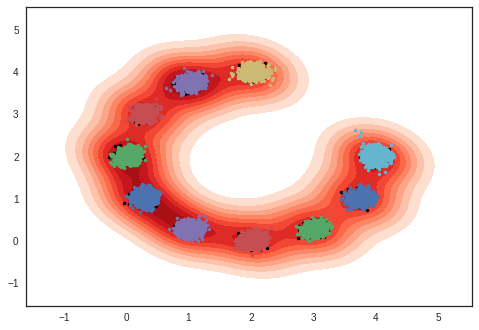

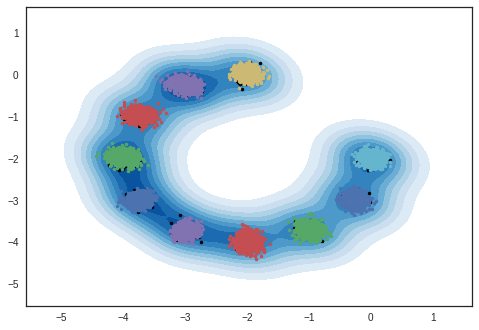

 50%|████▉     | 24996/50000 [05:36<05:24, 77.08it/s]

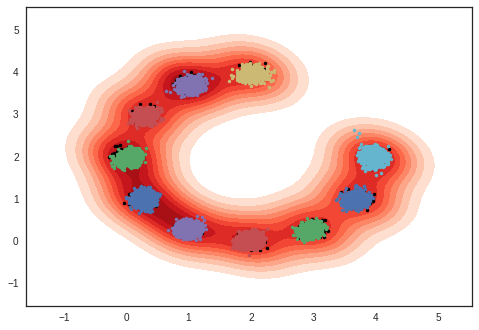

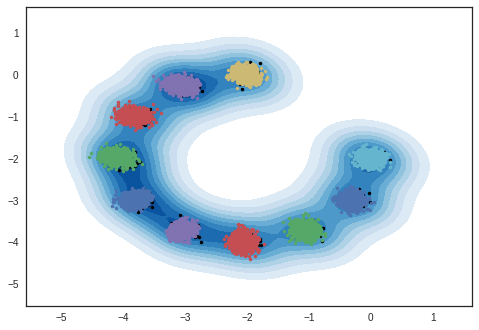

 52%|█████▏    | 25754/50000 [05:47<05:14, 77.12it/s]

In [ ]:
max_iteration = 50000
idx = 0

A_loader, B_loader = iter(A_train_loader), iter(B_train_loader)

for idx in trange(max_iteration):
    try:
        x_A, x_B = A_loader.next()[0], B_loader.next()[0]
    except StopIteration:
        A_loader, B_loader = iter(A_train_loader), iter(B_train_loader)
        x_A, x_B = A_loader.next()[0], B_loader.next()[0]

    x_A, x_B = Variable(x_A.cuda()), Variable(x_B.cuda())
    batch_size = x_A.size(0)

    real_tensor.data.resize_(batch_size).fill_(real_label)
    fake_tensor.data.resize_(batch_size).fill_(fake_label)

    # update D network
    D_A.zero_grad()
    D_B.zero_grad()

    x_AB = G_AB(x_A).detach()
    x_BA = G_BA(x_B).detach()

    x_ABA = G_BA(x_AB).detach()
    x_BAB = G_AB(x_BA).detach()

    l_d_A_real, l_d_A_fake = bce(D_A(x_A), real_tensor), bce(D_A(x_BA), fake_tensor)
    l_d_B_real, l_d_B_fake = bce(D_B(x_B), real_tensor), bce(D_B(x_AB), fake_tensor)

    l_d_A = l_d_A_real + l_d_A_fake
    l_d_B = l_d_B_real + l_d_B_fake

    l_d = l_d_A + l_d_B

    l_d.backward()
    optimizer_d.step()

    # update G network
    G_AB.zero_grad()
    G_BA.zero_grad()

    x_AB = G_AB(x_A)
    x_BA = G_BA(x_B)

    x_ABA = G_BA(x_AB)
    x_BAB = G_AB(x_BA)

    l_const_A = d(x_ABA, x_A)
    l_const_B = d(x_BAB, x_B)

    l_gan_A = bce(D_A(x_BA), real_tensor)
    l_gan_B = bce(D_B(x_AB), real_tensor)

    l_g = l_gan_A + l_gan_B + l_const_A + l_const_B

    l_g.backward()
    optimizer_g.step()

    if idx % (max_iteration/20) == 0:
        #print("[{}/{}] Loss_D: {:.4f} Loss_G: {:.4f}". \
        #      format(idx, max_iteration, l_d.data[0], l_g.data[0]))

        #print("[{}/{}] l_d_A_real: {:.4f} l_d_A_fake: {:.4f}, l_d_B_real: {:.4f}, l_d_B_fake: {:.4f}". \
        #      format(idx, max_iteration, l_d_A_real.data[0], l_d_A_fake.data[0],  
        #             l_d_B_real.data[0], l_d_B_fake.data[0]))

        #print("[{}/{}] l_const_A: {:.4f} l_const_B: {:.4f}, l_gan_A: {:.4f}, l_gan_B: {:.4f}". \
        #      format(idx, max_iteration, l_const_A.data[0], l_const_B.data[0],  
        #             l_gan_A.data[0], l_gan_B.data[0]))

        plt.figure()
        ax = sns.kdeplot(B_test_np[:1000],
                         cmap="Reds", shade=True, shade_lowest=False)

        plot(B_test_np[:1000], 'k.')
        for key, value in A_data_with_class.items():
            data = torch.from_numpy(value[:1000]).float()
            pred = G_AB(Variable(data).cuda()).data.cpu().numpy()
            plot(pred, '.')

        plt.figure()
        ax = sns.kdeplot(A_test_np[:1000],
                         cmap="Blues", shade=True, shade_lowest=False)
        
        plot(A_test_np[:1000], 'k.')
        for key, value in B_data_with_class.items():
            data = torch.from_numpy(value[:1000]).float()
            pred = G_BA(Variable(data).cuda()).data.cpu().numpy()
            plot(pred, '.')
    
        #ax = sns.kdeplot(G_AB(Variable(A_test[:1000]).cuda()).data.cpu().numpy(),
        #     cmap="Reds", shade=True, shade_lowest=False)
        #ax = sns.kdeplot(G_BA(Variable(B_test[:1000]).cuda()).data.cpu().numpy(),
        #                 cmap="Blues", shade=True, shade_lowest=False)

        plt.show()
        plt.pause(0.05)

In [ ]:
Variable(torch.FloatTensor(batch_size)).cuda()